# Class Challenge: Image Classification of COVID-19 X-rays
# Task 1 [Total points: 30]

## Setup

* This assignment involves the following packages: 'matplotlib', 'numpy', and 'sklearn'. 

* If you are using conda, use the following commands to install the above packages:<br>
```shell
conda install matplotlib
conda install numpy
conda install -c anaconda scikit-learn
```

* If you are using pip, use use the following commands to install the above packages: <br> 
```shell
pip install matplotlib
pip install numpy
pip install sklearn
```

## Data

Please download the data using the following link: [COVID-19](https://drive.google.com/file/d/1Y88tgqpQ1Pjko_7rntcPowOJs_QNOrJ-/view). 

* After downloading 'Covid_Data_GradientCrescent.zip', unzip the file and you should see the following data structure:


|--all<br>
|--------train<br>
|--------test<br>
|--two<br>
|--------train<br>
|--------test<br>


* Put the 'all' folder, the 'two' folder and this python notebook in the **same directory** so that the following code can correctly locate the data.  



## [20 points] Binary Classification: COVID-19 vs. Normal

In [1]:
import os

import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
tf.__version__

2023-01-24 14:40:07.720966: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


'2.10.0'

#### Load Image Data

In [2]:
DATA_LIST = os.listdir('../Data/Covid_Data_GradientCrescent/two/train')
DATASET_PATH  = '../Data/Covid_Data_GradientCrescent/two/train'
TEST_DIR =  '../Data/Covid_Data_GradientCrescent/two/test'
IMAGE_SIZE    = (224, 224)
NUM_CLASSES   = len(DATA_LIST)
BATCH_SIZE    = 10  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    = 40
LEARNING_RATE = 0.00001 # start off with high rate first 0.001 and experiment with reducing it gradually 

#### Generate Training and Validation Batches

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   channel_shift_range = 20,
                                   validation_split = 0.2,fill_mode='constant')

train_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "training",seed=42,
                                                  class_mode="binary")

valid_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "validation",seed=42,
                                                  class_mode="binary")

Found 104 images belonging to 2 classes.
Found 26 images belonging to 2 classes.


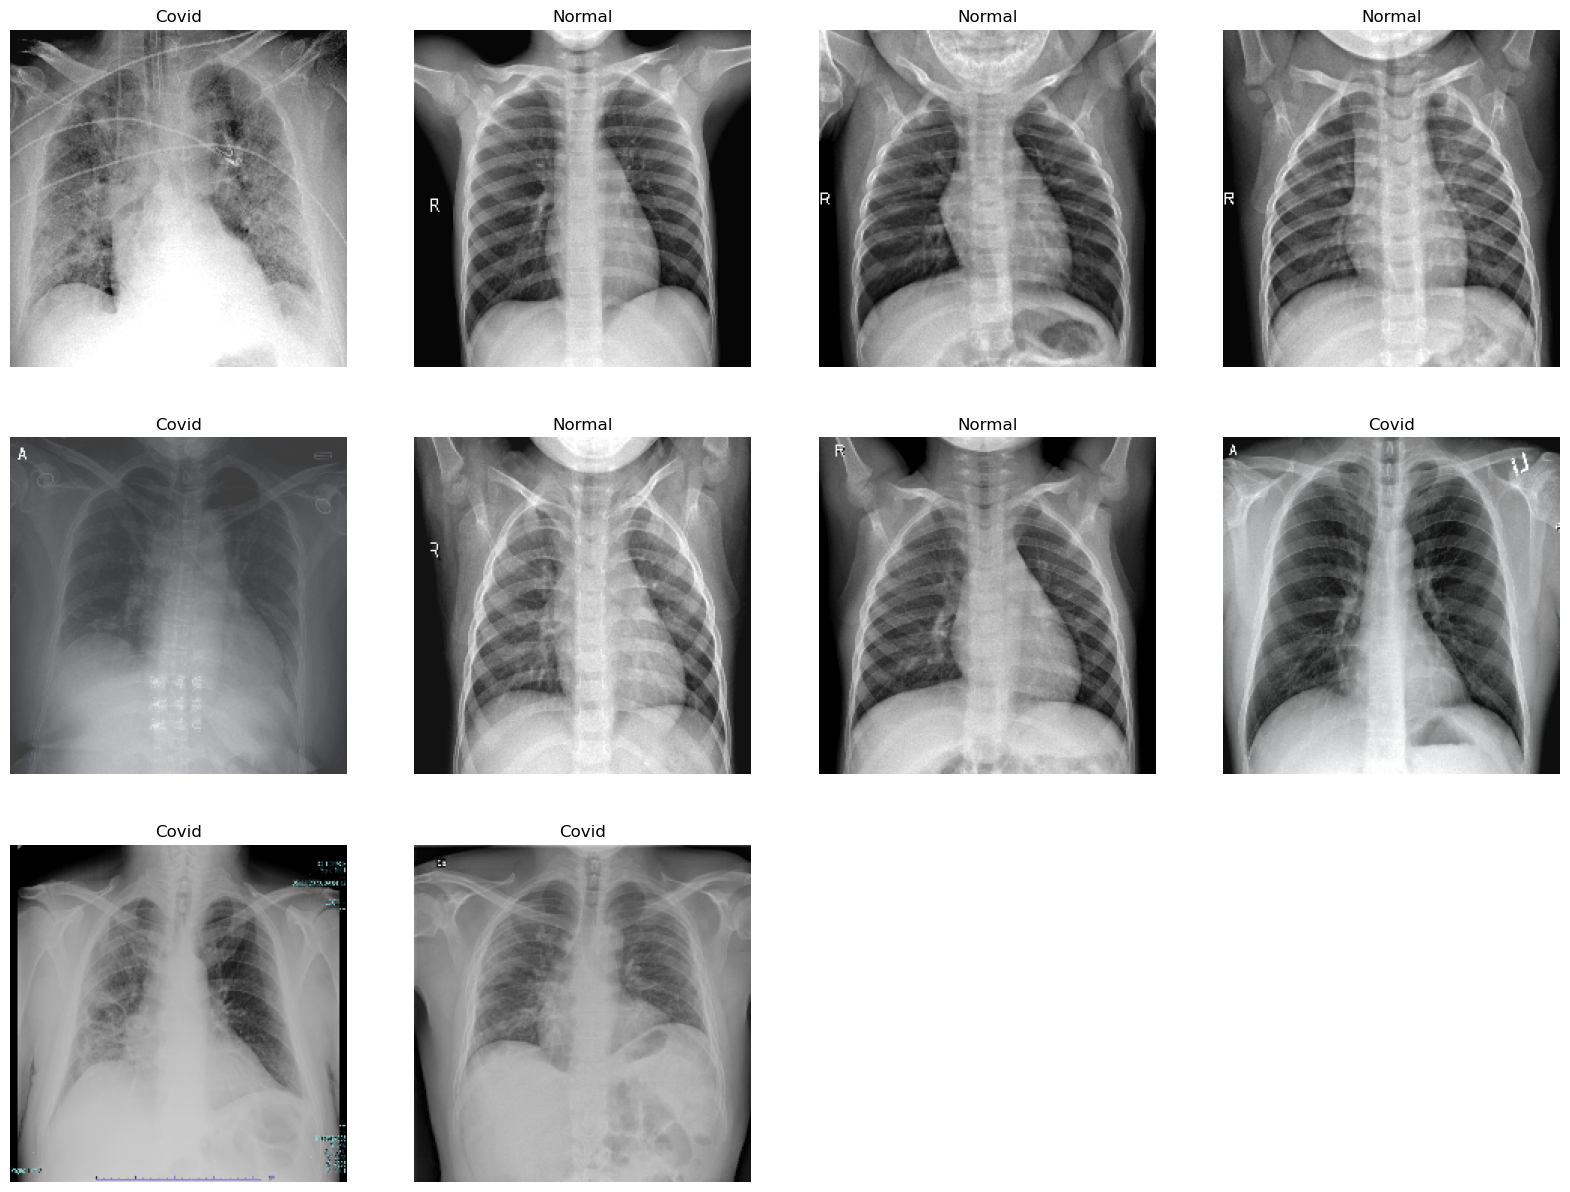

In [4]:
def image_plot(generator,image_numbers):
    img_feature = generator[0][0][:image_numbers]
    img_label = generator[0][1][:image_numbers]

    plt.figure(figsize=(20, 15))
    for i in range(image_numbers):
        ax = plt.subplot(math.ceil(image_numbers/4),4, i + 1)
        plt.imshow(img_feature[i])
        plt.title("Covid" if img_label[i] == 0 else "Normal")
        plt.axis("off")

image_plot(train_batches,10)

#### [10 points] Build Model
Hint: Starting from a pre-trained model typically helps performance on a new task, e.g. starting with weights obtained by training on ImageNet. 

In [5]:
VGG16= tf.keras.applications.VGG16(include_top=False,weights="imagenet",input_shape=(224, 224, 3))
model = tf.keras.models.Sequential([
  VGG16,
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu', name='dense_feature1'),
  tf.keras.layers.Dropout(0.7),
  tf.keras.layers.Dense(128, activation='relu', name='dense_feature2'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1, activation='sigmoid')
  
])
model.summary()

2023-01-24 14:40:32.513832: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense_feature1 (Dense)      (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_feature2 (Dense)      (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 1

In [6]:
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

#### [5 points] Train Model

In [7]:
#FIT MODEL
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/vgg16_best.h5', monitor='accuracy', verbose=1, mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=5)

callbacks_list = [checkpoint,early]
history = model.fit(train_batches,  epochs=NUM_EPOCHS, validation_data=valid_batches,shuffle=False, 
        verbose=True, callbacks=callbacks_list) # Use correct args here.

Epoch 1/40
11/11 [==============================] - ETA: 0s - loss: 0.8173 - accuracy: 0.5577 
Epoch 1: accuracy improved from -inf to 0.55769, saving model to model/vgg16_best.h5
11/11 [==============================] - 176s 16s/step - loss: 0.8173 - accuracy: 0.5577 - val_loss: 0.5755 - val_accuracy: 0.8846
Epoch 2/40
11/11 [==============================] - ETA: 0s - loss: 0.8192 - accuracy: 0.5385 
Epoch 2: accuracy did not improve from 0.55769
11/11 [==============================] - 151s 14s/step - loss: 0.8192 - accuracy: 0.5385 - val_loss: 0.4823 - val_accuracy: 0.9231
Epoch 3/40
11/11 [==============================] - ETA: 0s - loss: 0.6022 - accuracy: 0.7115 
Epoch 3: accuracy improved from 0.55769 to 0.71154, saving model to model/vgg16_best.h5
11/11 [==============================] - 160s 15s/step - loss: 0.6022 - accuracy: 0.7115 - val_loss: 0.3688 - val_accuracy: 0.9615
Epoch 4/40
11/11 [==============================] - ETA: 0s - loss: 0.4982 - accuracy: 0.7308 
Epoch 4

11/11 [==============================] - ETA: 0s - loss: 0.0302 - accuracy: 0.9808 
Epoch 29: accuracy did not improve from 1.00000
11/11 [==============================] - 176s 16s/step - loss: 0.0302 - accuracy: 0.9808 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 30/40
11/11 [==============================] - ETA: 0s - loss: 0.0143 - accuracy: 1.0000 
Epoch 30: accuracy did not improve from 1.00000
11/11 [==============================] - 173s 16s/step - loss: 0.0143 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 31/40
11/11 [==============================] - ETA: 0s - loss: 0.0072 - accuracy: 1.0000 
Epoch 31: accuracy did not improve from 1.00000
11/11 [==============================] - 173s 16s/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 1.0000


#### [5 points] Plot Accuracy and Loss During Training

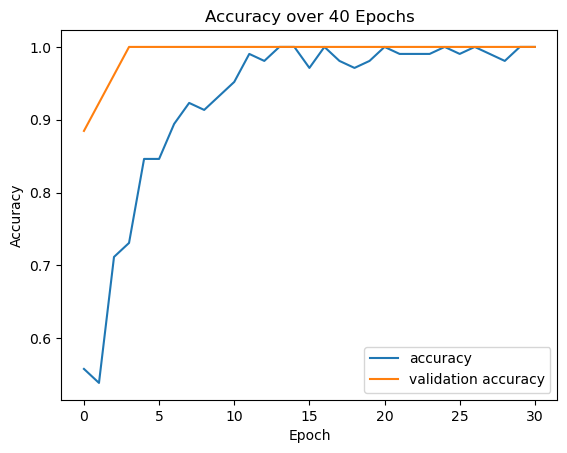

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over 40 Epochs')
plt.legend(loc='lower right')


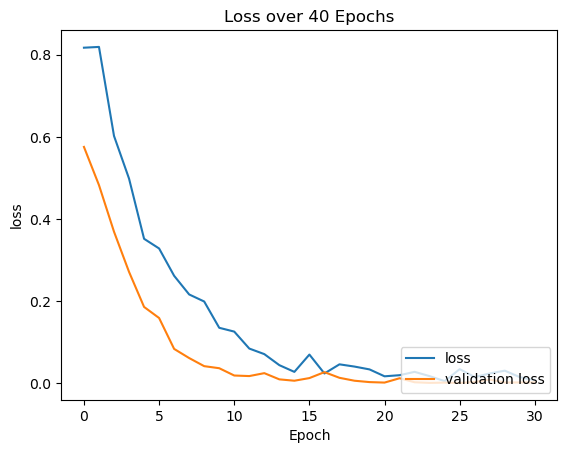

In [16]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('Loss over 40 Epochs')
plt.legend(loc='lower right')

#### Plot Test Results

Found 18 images belonging to 2 classes.


/var/folders/2w/r4bgqlv108jffbghr56v0x780000gn/T/ipykernel_50211/3978465178.py:7: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = model.predict_generator(eval_generator,18,verbose=1)


18/18 [==============================] - 9s 417ms/step
covid/nejmoa2001191_f3-PA.jpeg


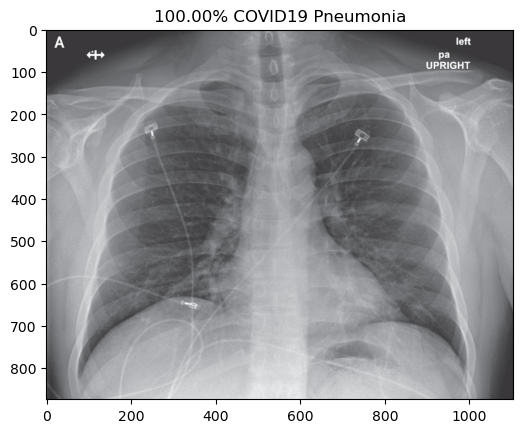

covid/nejmoa2001191_f4.jpeg


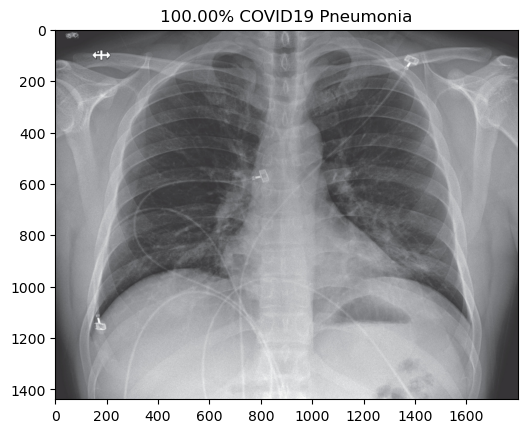

covid/nejmoa2001191_f5-PA.jpeg


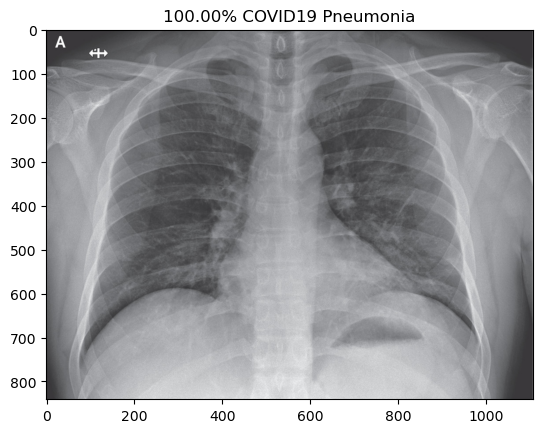

covid/radiol.2020200490.fig3.jpeg


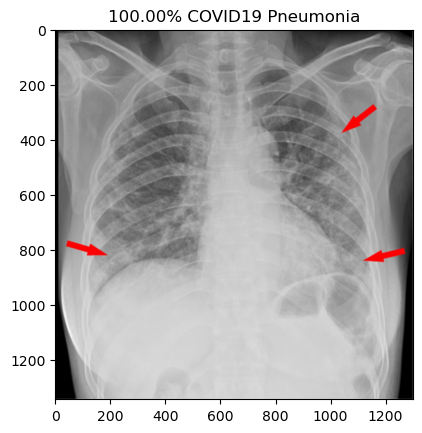

covid/ryct.2020200028.fig1a.jpeg


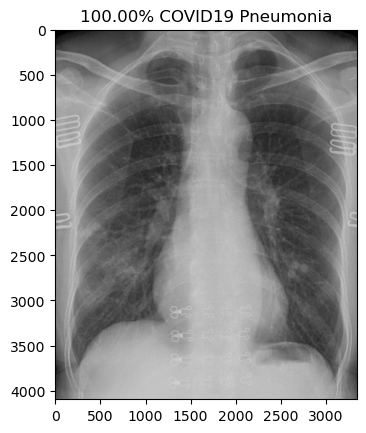

covid/ryct.2020200034.fig2.jpeg


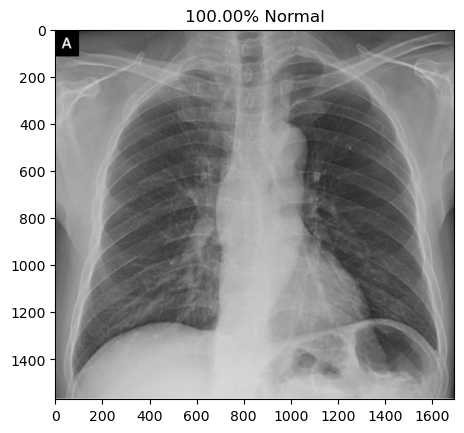

covid/ryct.2020200034.fig5-day0.jpeg


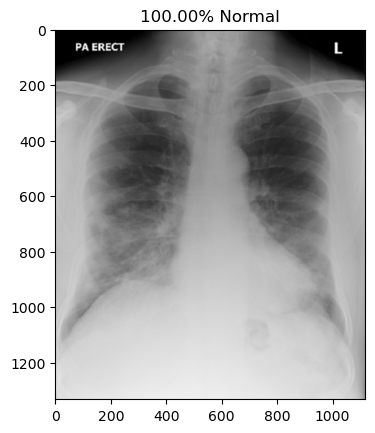

covid/ryct.2020200034.fig5-day4.jpeg


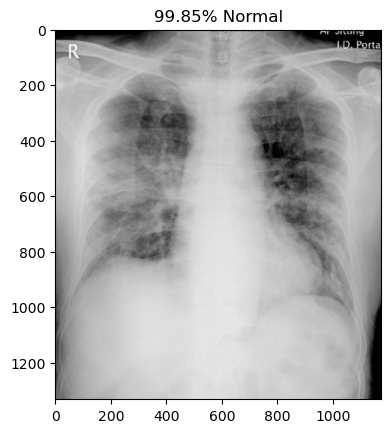

covid/ryct.2020200034.fig5-day7.jpeg


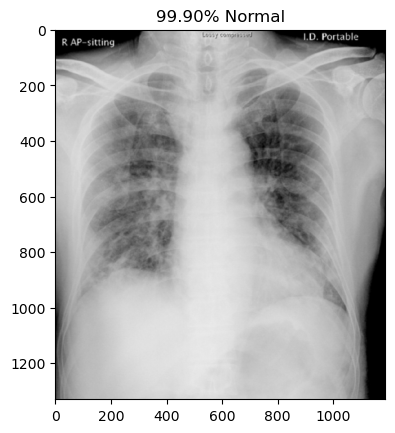

normal/NORMAL2-IM-1385-0001.jpeg


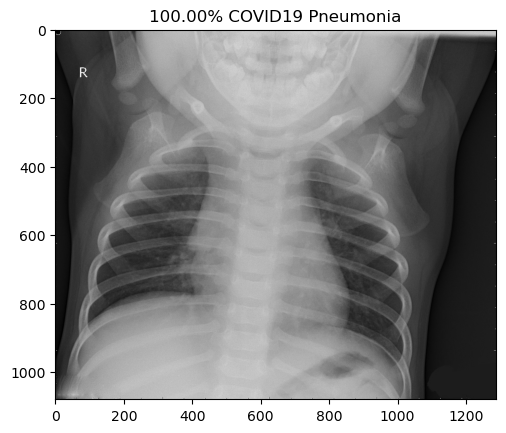

normal/NORMAL2-IM-1396-0001.jpeg


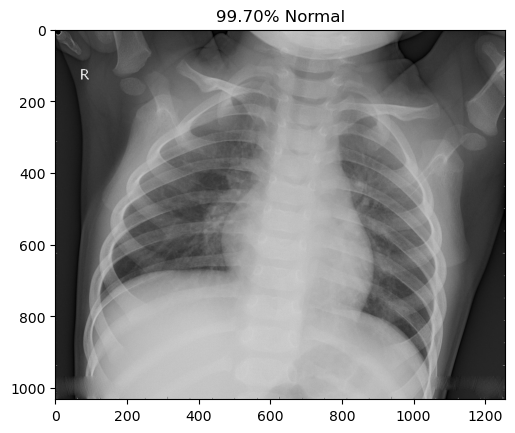

normal/NORMAL2-IM-1400-0001.jpeg


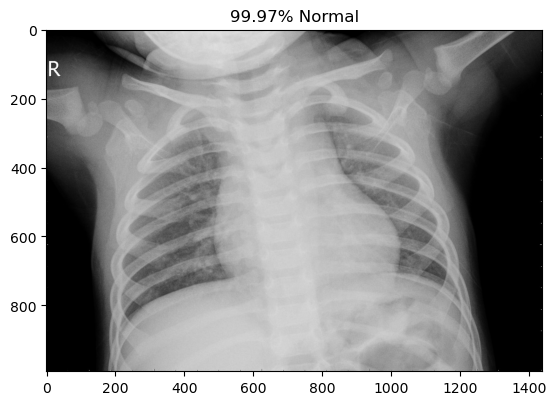

normal/NORMAL2-IM-1401-0001.jpeg


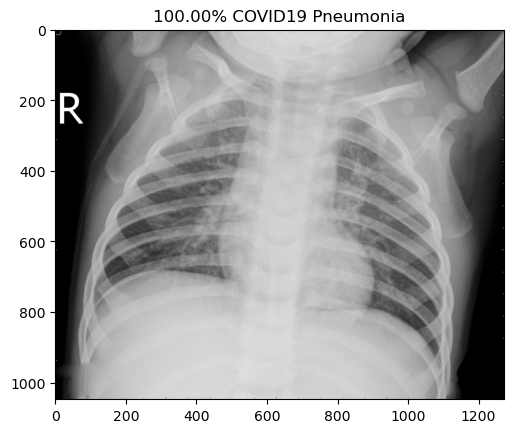

normal/NORMAL2-IM-1406-0001.jpeg


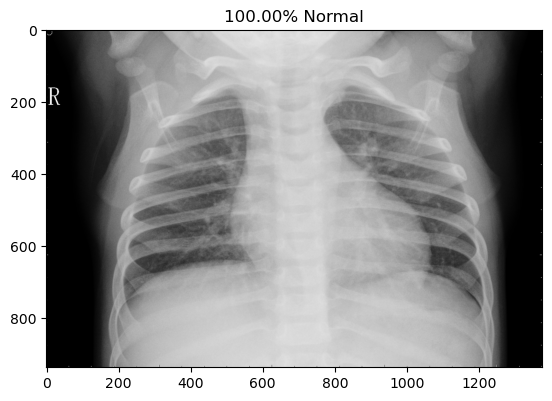

normal/NORMAL2-IM-1412-0001.jpeg


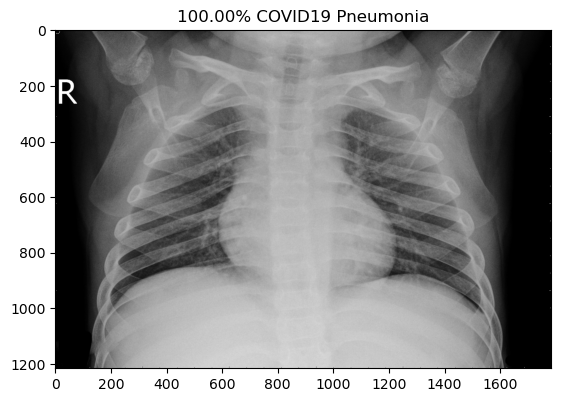

normal/NORMAL2-IM-1419-0001.jpeg


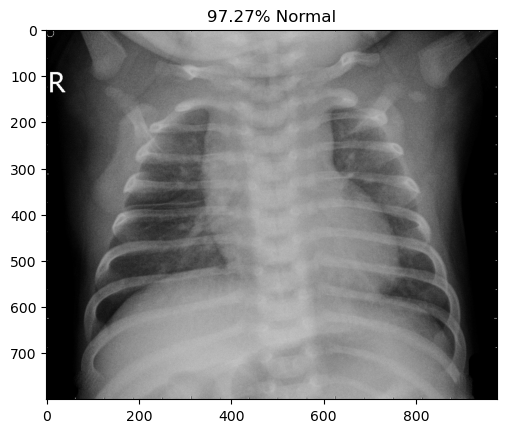

normal/NORMAL2-IM-1422-0001.jpeg


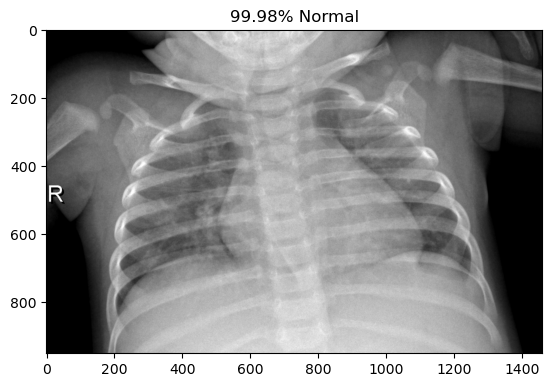

normal/NORMAL2-IM-1423-0001.jpeg


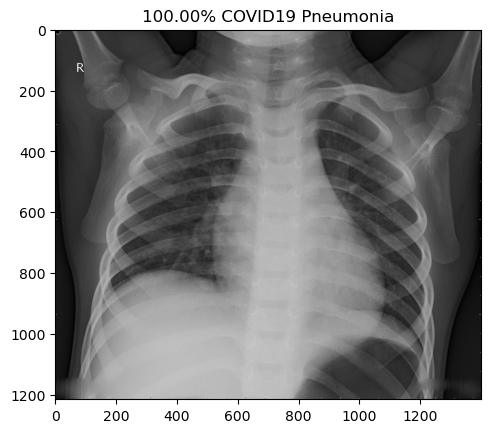

In [10]:
import matplotlib.image as mpimg

test_datagen = ImageDataGenerator(rescale=1. / 255)
eval_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=True,seed=42,class_mode="binary")
eval_generator.reset()
pred = model.predict_generator(eval_generator,18,verbose=1)
for index, probability in enumerate(pred):
    image_path = TEST_DIR + "/" +eval_generator.filenames[index]
    image = mpimg.imread(image_path)
    if image.ndim < 3:
        image = np.reshape(image,(image.shape[0],image.shape[1],1))
        image = np.concatenate([image, image, image], 2)

    pixels = np.array(image)
    plt.imshow(pixels)
    
    print(eval_generator.filenames[index])
    if probability > 0.5:
        plt.title("%.2f" % (probability[0]*100) + "% Normal")
    else:
        plt.title("%.2f" % ((1-probability[0])*100) + "% COVID19 Pneumonia")
    plt.show()

In [11]:
x = model.evaluate_generator(eval_generator,steps = np.ceil(len(eval_generator)),
                           use_multiprocessing = False,verbose = 1,workers=1)
print('Test loss:' , x[0])
print('Test accuracy:',x[1])

/var/folders/2w/r4bgqlv108jffbghr56v0x780000gn/T/ipykernel_50211/4043133743.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  x = model.evaluate_generator(eval_generator,steps = np.ceil(len(eval_generator)),


18/18 [==============================] - 7s 357ms/step - loss: 0.0019 - accuracy: 1.0000
Test loss: 0.0018748914590105414
Test accuracy: 1.0


## [10 points] TSNE Plot
t-Distributed Stochastic Neighbor Embedding (t-SNE) is a widely used technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. After training is complete, extract features from a specific deep layer of your choice, use t-SNE to reduce the dimensionality of your extracted features to 2 dimensions and plot the resulting 2D features.

In [12]:
from sklearn.manifold import TSNE
from tensorflow.keras import models,layers,optimizers

intermediate_layer_model = models.Model(inputs=model.input,
                                        outputs=model.get_layer('dense_feature2').output)
tsne_data_generator = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=True,seed=42,class_mode="binary")

labels = []
tsne_inputs = []
for i in range(len(tsne_data_generator)):
    feature, label = tsne_data_generator[i]
    y = intermediate_layer_model(feature)
    if label == 0:
        labels.append("Normal")
    else:
        labels.append("Covid")
    tsne_inputs.append(y[0])
tsne_inputs = np.array(tsne_inputs)


Found 130 images belonging to 2 classes.


In [13]:
tsne_result = TSNE(n_components=2, random_state=0).fit_transform(tsne_inputs)
tsne_result.shape

(130, 2)

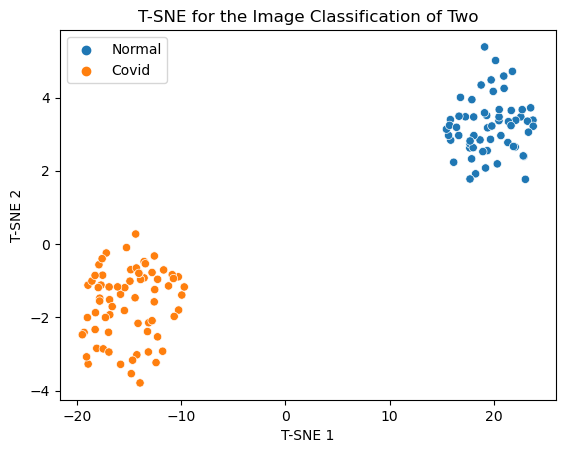

In [14]:
tsne_result_df = pd.DataFrame({'T-SNE 1': tsne_result[:,0], 'T-SNE 2': tsne_result[:,1], 'label': labels})
sns.scatterplot(x='T-SNE 1', y='T-SNE 2', hue='label', data=tsne_result_df)
plt.title("T-SNE for the Image Classification of Two")
plt.legend()
plt.show()
                

<!-- ## Task 2: COVID-19 vs Normal vs Tertiary Pneumonia (Bacterial and Viral) -->

<!-- #### Renew Training Batch and Validation Batch -->

<!-- #### Renew Model -->